# MODELING V3 FEB21

### LOADING LIBRARIES

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline

### DEFINING NECESSARY FUNCTIONS

In [2]:
def max_pooling_batch(matrices, new_shape):
    original_batch, original_height, original_width = matrices.shape  
    target_height, target_width = new_shape
    pool_size = original_width // target_width
    reshaped = matrices.reshape(original_batch, original_height, target_width, pool_size)
    pooled = np.max(reshaped, axis=3)
    return pooled

def count_and_percentage(array):
    flattened = array.flatten()
    unique, counts = np.unique(flattened, return_counts=True)
    total_elements = flattened.size
    count_dict = dict(zip(unique, counts))
    percentage_dict = {key: (value / total_elements) * 100 for key, value in count_dict.items()}
    return count_dict, percentage_dict

def resize_tensor_bilinear(tensor, target_size, mode='bilinear'):
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode, align_corners=False)
    return resized.squeeze(0)

def resize_tensor_nearest(tensor, target_size, mode='nearest'):
    tensor = tensor.unsqueeze(0)
    resized = F.interpolate(tensor, size=target_size, mode=mode)
    return resized.squeeze(0)


def normalize_tensor(tensor):
    min_val = tensor.min(dim=-1, keepdim=True).values.min(dim=-2, keepdim=True).values
    max_val = tensor.max(dim=-1, keepdim=True).values.max(dim=-2, keepdim=True).values
    return ((tensor - min_val) / ((max_val - min_val) + 1e-8))

### LOADING DATA

##### LOADING ELEVATION, VEGETATION, SOIL VARIABLE AND SOIL COMPOSITION

In [3]:
#SPATIAL MASK
spatial_mask = np.load("Spatial_Mask.npy")

#ELEVATION DATA
elevation_data = np.load('elevation_matrix.npy') 

#VEGETATION DATA
vegetation_data = np.load('NLCD2021_OR.npy') 

#SOIL VARIABLE DATA
directory = "ERA5_matrices"  
npy_files = sorted([f for f in os.listdir(directory) if f.endswith('.npy')])
matrices = [np.load(os.path.join(directory, file)) for file in npy_files]
data = np.stack(matrices, axis=0)  # Shape: (num_files, height, width)
soil_variable_data = np.transpose(data, (1, 0, 2, 3)) 

#SOIL COMPOSITION DATA
data_folder = "SOLUS"
npy_files = [f for f in os.listdir(data_folder) if f.endswith('.npy')]
num_files = len(npy_files)
transformed_data_list = []
pca = PCA(n_components=1)
for file in npy_files:
    file_path = os.path.join(data_folder, file)
    soil_data = np.load(file_path)
    reshaped_data = soil_data.reshape(7, -1).T
    principal_component = pca.fit_transform(reshaped_data)  
    reduced_data = principal_component.reshape(1306, 464)
    transformed_data_list.append(reduced_data)
soil_composition_data = np.stack(transformed_data_list, axis=0) 

In [4]:
print(f"SPATIAL MASK : {spatial_mask.shape}")
print(f"ELEVATION DATA : {elevation_data.shape}")
print(f"VEGETATION DATA : {vegetation_data.shape}")
print(f"SOIL VARIABLE DATA : {soil_variable_data.shape}")
print(f"SOIL COMPOSITION DATA : {soil_composition_data.shape}")


SPATIAL MASK : (120, 120)
ELEVATION DATA : (10812, 10812)
VEGETATION DATA : (15, 4353, 1547)
SOIL VARIABLE DATA : (1096, 28, 5, 5)
SOIL COMPOSITION DATA : (18, 1306, 464)


##### LOADING OUTPUT LABELS

In [5]:
label = np.load('landslide_labels_stored_sequentially_compressed.npz') 
output_labels = label['matrix']
labels_resized = max_pooling_batch(output_labels, (120, 120))  # Output shape: (1096, 120, 120)
counts, percentages = count_and_percentage(labels_resized)
print("Counts:", counts)  
print("Percentages:", percentages)

Counts: {0.0: 15118676, 1.0: 303439, 2.0: 360285}
Percentages: {0.0: 95.79453061638281, 1.0: 1.9226416768045418, 2.0: 2.282827706812652}


In [6]:
print(f"OUTPUT LABELS : {labels_resized.shape}")

OUTPUT LABELS : (1096, 120, 120)


### CONVERTING NUMPY ARRAYS TO TENSORS

In [7]:
elevation_data = torch.tensor(elevation_data, dtype=torch.float).unsqueeze(0)  # (1, 10812, 10812)
vegetation_data = torch.tensor(vegetation_data, dtype=torch.float)             # (15, 4353, 1547)
soil_composition_data = torch.tensor(soil_composition_data, dtype=torch.float) # (18, 1306, 464)
soil_variable_data = torch.tensor(soil_variable_data, dtype=torch.float)       # (1096, 28, 5, 5)
output_labels = torch.tensor(labels_resized, dtype=torch.long)                 # (1096, 120, 120)

In [8]:
print(f"ELEVATION DATA : {elevation_data.shape}")
print(f"VEGETATION DATA : {vegetation_data.shape}")
print(f"SOIL VARIABLE DATA : {soil_variable_data.shape}")
print(f"SOIL COMPOSITION DATA : {soil_composition_data.shape}")
print(f"OUTPUT LABELS : {output_labels.shape}")

ELEVATION DATA : torch.Size([1, 10812, 10812])
VEGETATION DATA : torch.Size([15, 4353, 1547])
SOIL VARIABLE DATA : torch.Size([1096, 28, 5, 5])
SOIL COMPOSITION DATA : torch.Size([18, 1306, 464])
OUTPUT LABELS : torch.Size([1096, 120, 120])


### PREPROCESSING THE TENSORS

##### TARGET SPATIAL RESOLUTION (HEIGHT,WIDTH)

In [9]:
target_size = (120, 120)

##### PRE-RESIZE STATIC DATASETS (DO NOT CHANGE BY THE DAY)

In [10]:
import torch
import torch.nn as nn

# 1. Elevation Data: Input assumed to be (batch, 1, 10812, 10812)
#    Expected output: (batch, 1, 120, 120)
class ElevationNet(nn.Module):
    def __init__(self):
        super(ElevationNet, self).__init__()
        self.conv = nn.Sequential(
            # Use a larger stride to quickly reduce the huge input resolution.
            nn.Conv2d(1, 8, kernel_size=7, stride=4, padding=3),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Map back to one channel.
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        # Adaptive pooling will output (120,120) regardless of the spatial size.
        self.adaptive_pool = nn.AdaptiveAvgPool2d((120, 120))
        
    def forward(self, x):
        x = self.conv(x)
        x = self.adaptive_pool(x)
        return x

# 2. Vegetation Data: Input shape (batch, 15, 4353, 1547)
#    Expected output: (batch, 15, 120, 120)
class VegetationNet(nn.Module):
    def __init__(self):
        super(VegetationNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=7, stride=4, padding=3),
            nn.ReLU(),
            # Map back to 15 channels.
            nn.Conv2d(32, 15, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((120, 120))
        
    def forward(self, x):
        x = self.conv(x)
        x = self.adaptive_pool(x)
        return x

# 3. Soil Variable Data: Input shape (batch, 28, 5, 5) with batch=1096
#    Expected output: (batch, 28, 120, 120)
#    Because the spatial size is very small, we use upsampling.
class SoilVariableNet(nn.Module):
    def __init__(self):
        super(SoilVariableNet, self).__init__()
        self.conv = nn.Sequential(
            # A simple convolutional block that preserves the 28 channels.
            nn.Conv2d(28, 28, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Use bilinear upsampling to scale from 5x5 to 120x120.
        self.upsample = nn.Upsample(size=(120, 120), mode='bilinear', align_corners=False)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        return x

# 4. Soil Composition Data: Input shape (batch, 18, 1306, 464)
#    Expected output: (batch, 18, 120, 120)
class SoilCompositionNet(nn.Module):
    def __init__(self):
        super(SoilCompositionNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(18, 32, kernel_size=7, stride=4, padding=3),
            nn.ReLU(),
            # Map back to 18 channels.
            nn.Conv2d(32, 18, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((120, 120))
        
    def forward(self, x):
        x = self.conv(x)
        x = self.adaptive_pool(x)
        return x

# Example usage with dummy data:
if __name__ == '__main__':
    # # Create dummy inputs with the assumed shapes.
    # elevation_data = torch.randn(1, 1, 10812, 10812)       # single sample, 1 channel
    # vegetation_data = torch.randn(1, 15, 4353, 1547)        # single sample, 15 channels
    # soil_variable_data = torch.randn(1096, 28, 5, 5)         # 1096 samples, 28 channels
    # soil_composition_data = torch.randn(1, 18, 1306, 464)    # single sample, 18 channels
    
    # Initialize models.
    elev_net = ElevationNet()
    veg_net = VegetationNet()
    soil_comp_net = SoilCompositionNet()
    soil_var_net = SoilVariableNet()

    with torch.no_grad():
        # Forward pass.
        elevation_resized = elev_net(elevation_data)          # expected shape: (1, 1, 120, 120)
        vegetation_resized = veg_net(vegetation_data)           # expected shape: (1, 15, 120, 120)
        soil_variable_resized = soil_var_net(soil_variable_data)  # expected shape: (1096, 28, 120, 120)
        soil_composition_resized = soil_comp_net(soil_composition_data)  # expected shape: (1, 18, 120, 120)
        
        # Print output shapes.
        print("Elevation output shape:", elevation_resized.shape)
        print("Vegetation output shape:", vegetation_resized.shape)
        print("Soil Variable output shape:", soil_variable_resized.shape)
        print("Soil Composition output shape:", soil_composition_resized.shape)

Elevation output shape: torch.Size([1, 120, 120])
Vegetation output shape: torch.Size([15, 120, 120])
Soil Variable output shape: torch.Size([1096, 28, 120, 120])
Soil Composition output shape: torch.Size([18, 120, 120])


In [11]:
# elevation_resized = resize_tensor_bilinear(elevation_data, target_size)                # -> (1, 120, 120)
# vegetation_resized = resize_tensor_nearest(vegetation_data, target_size)                # -> (15, 120, 120)
# soil_composition_resized = resize_tensor_bilinear(soil_composition_data, target_size)  # -> (18, 120, 120)
# #soil_variable_resized = F.interpolate(soil_variable_data, size=target_size, mode='bilinear', align_corners=False)  # -> (1096, 28, 120, 120)

In [12]:
# print(f"ELEVATION DATA : {elevation_resized.shape}")
# print(f"VEGETATION DATA : {vegetation_resized.shape}")
# print(f"SOIL COMPOSITION DATA : {soil_composition_resized.shape}")

##### NORMALIZE THE CONTINOUS FEATURES (ELEVATION AND SOIL COMPOSITION)

In [13]:
elevation_normalized = (elevation_resized - elevation_resized.min()) / (elevation_resized.max() - elevation_resized.min())
soil_composition_normalized = torch.stack([normalize_tensor(t1) for t1 in soil_composition_resized])
soil_variable_normalized = torch.stack([normalize_tensor(t2) for t2 in soil_variable_resized])

In [14]:
print(f"ELEVATION DATA : {elevation_normalized.shape}")
print(f"VEGETATION DATA : {vegetation_resized.shape}")
print(f"SOIL COMPOSITION DATA : {soil_composition_normalized.shape}")
print(f"SOIL VARIABLE DATA : {soil_variable_normalized.shape}")
print(f"OUTPUT LABELS : {output_labels.shape}")

ELEVATION DATA : torch.Size([1, 120, 120])
VEGETATION DATA : torch.Size([15, 120, 120])
SOIL COMPOSITION DATA : torch.Size([18, 120, 120])
SOIL VARIABLE DATA : torch.Size([1096, 28, 120, 120])
OUTPUT LABELS : torch.Size([1096, 120, 120])


In [15]:
print(torch.isnan(elevation_normalized).any())
print(torch.isnan(vegetation_resized).any())
print(torch.isnan(soil_composition_normalized).any())
print(torch.isnan(soil_variable_data).any())
print(torch.isnan(output_labels).any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


### CUSTOM DATASET CLASS

In [16]:
class DayDataset(Dataset):
    def __init__(self, day_indices, vegetation, elevation, soil_comp, soil_var, labels, target_size):
        """
        Args:
          day_indices: list of day indices (e.g., [0, 1, 2, ...])
          vegetation: static vegetation data, already resized, shape (15, target_H, target_W)
          elevation: static elevation data, already resized, shape (1, target_H, target_W)
          soil_comp: static soil composition data, already resized, shape (18, target_H, target_W)
          soil_var: daily soil variable data, shape (1096, 28, 5, 5)
          labels: daily output labels, shape (1096, target_H, target_W)
          target_size: the target spatial size (target_H, target_W) for all inputs
        """
        self.day_indices = day_indices
        self.vegetation = vegetation
        self.elevation = elevation
        self.soil_comp = soil_comp
        self.soil_var = soil_var
        self.labels = labels
        self.target_size = target_size

    def __len__(self):
        return len(self.day_indices)

    def __getitem__(self, idx):
        day = self.day_indices[idx]
        soil_var_day = self.soil_var[day]
        # soil_var_net = SoilVariableNet()

        
        # soil_var_day_resized = resize_tensor_bilinear(soil_var_day, self.target_size)
        # soil_variable_normalized = torch.stack([normalize_tensor(t2) for t2 in soil_var_day_resized])
        
        
        input_tensor = torch.cat([self.vegetation, self.elevation, self.soil_comp, soil_var_day], dim=0)
        label = self.labels[day]
        #print(f"INPUT TENSOR WITH MISSING VALUE : {torch.isnan(input_tensor).any()}")
        return input_tensor, label

##### DEFINING TRAIN DAYS, VALIDATION DAYS AND TEST DAYS 

In [17]:
# all_days = list(range(1096))
# train_days = list(range(0, 730))
# test_days = list(range(730, 1096))
# val_days = train_days[-100:] 
# train_days = train_days[:-100]
all_days = list(range(1096))
train_days = list(range(0, 730))
test_days = list(range(730, 1096))
val_days = random.sample(train_days, 100) # Randomly select 100 days from train_days for validation
train_days = [day for day in train_days if day not in val_days] # Remove the selected validation days from train_days

##### CREATING DATASETS AND DATALOADERS

In [18]:
# train_dataset = DayDataset(train_days, vegetation_resized, elevation_normalized,
#                            soil_composition_normalized, soil_variable_data, output_labels, target_size)
# val_dataset = DayDataset(val_days, vegetation_resized, elevation_normalized,
#                          soil_composition_normalized, soil_variable_data, output_labels, target_size)
# test_dataset = DayDataset(test_days, vegetation_resized, elevation_normalized,
#                           soil_composition_normalized, soil_variable_data, output_labels, target_size)


train_dataset = DayDataset(train_days, vegetation_resized, elevation_normalized,
                           soil_composition_normalized, soil_variable_normalized, output_labels, target_size)
val_dataset = DayDataset(val_days, vegetation_resized, elevation_normalized,
                         soil_composition_normalized, soil_variable_normalized, output_labels, target_size)
test_dataset = DayDataset(test_days, vegetation_resized, elevation_normalized,
                          soil_composition_normalized, soil_variable_normalized, output_labels, target_size)


# train_dataset = DayDataset(train_days, vegetation_resized, elevation_resized,
#                            soil_composition_resized, soil_variable_data, output_labels, target_size)
# val_dataset = DayDataset(val_days, vegetation_resized, elevation_resized,
#                          soil_composition_resized, soil_variable_data, output_labels, target_size)
# test_dataset = DayDataset(test_days, vegetation_resized, elevation_resized,
#                           soil_composition_resized, soil_variable_data, output_labels, target_size)



batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### DEFINING FULLY CONVOLUTIONAL NETWORK (FCN)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottom (bottleneck)
        self.bottom = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),  # Concatenated channels from enc3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),  # Concatenated channels from enc2
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),    # Concatenated channels from enc1
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)   # (64, H, W)
        p1 = self.pool1(x1) # (64, H/2, W/2)

        x2 = self.enc2(p1)  # (128, H/2, W/2)
        p2 = self.pool2(x2) # (128, H/4, W/4)

        x3 = self.enc3(p2)  # (256, H/4, W/4)
        p3 = self.pool3(x3) # (256, H/8, W/8)

        # Bottleneck
        x_bottom = self.bottom(p3) # (512, H/8, W/8)

        # Decoder
        d3 = self.upconv3(x_bottom)        # (256, H/4, W/4)
        d3 = torch.cat([d3, x3], dim=1)      # (256 + 256, H/4, W/4)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)              # (128, H/2, W/2)
        d2 = torch.cat([d2, x2], dim=1)      # (128 + 128, H/2, W/2)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)              # (64, H, W)
        d1 = torch.cat([d1, x1], dim=1)      # (64 + 64, H, W)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)          # (num_classes, H, W)
        return out

# Example usage:
in_channels = 15 + 1 + 18 + 28  # As defined in your FCN
num_classes = 3
model = UNet(in_channels, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/shelly/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


UNet(
  (enc1): Sequential(
    (0): Conv2d(62, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottom): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=

In [20]:
# class FCN(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         """
#         A simple encoder-decoder Fully Convolutional Network.
#         Args:
#           in_channels: number of input channels (here, 62)
#           num_classes: number of output classes (here, 3 for labels 0, 1, 2)
#         """
#         super(FCN, self).__init__()
#         # Encoder: three conv layers with pooling
#         self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
#         self.bn1   = nn.BatchNorm2d(64)
#         self.pool1 = nn.MaxPool2d(2, 2)  

#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn2   = nn.BatchNorm2d(128)
#         self.pool2 = nn.MaxPool2d(2, 2)

#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn3   = nn.BatchNorm2d(256)
#         self.pool3 = nn.MaxPool2d(2, 2)

#         # Decoder: upsampling via transpose convolutions
#         self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.upconv3 = nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)

#     def forward(self, x):
#         # Encoder
#         x = F.relu(self.bn1(self.conv1(x)))    # (64, H, W)
#         x = self.pool1(x)                      # (64, H/2, W/2)

#         x = F.relu(self.bn2(self.conv2(x)))    # (128, H/2, W/2)
#         x = self.pool2(x)                      # (128, H/4, W/4)

#         x = F.relu(self.bn3(self.conv3(x)))    # (256, H/4, W/4)
#         x = self.pool3(x)                      # (256, H/8, W/8)

#         # Decoder (upsample back to original resolution)
#         x = self.upconv1(x)                    # (128, H/4, W/4)
#         x = self.upconv2(x)                    # (64, H/2, W/2)
#         x = self.upconv3(x)                    # (num_classes, H, W)
#         return x

# in_channels = 15 + 1 + 18 + 28  
# num_classes = 3
# model = FCN(in_channels, num_classes)
# #model = DeepResMultiScaleFCN(in_channels, num_classes)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

### TRAINING LOOP

##### DEFINING EARLY STOPPING

In [21]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

##### DEFINING THE LOSS FUNCTION AND OPTIMIZER

In [22]:
freq = torch.tensor([0.9579453061638281, 0.019226416768045418, 0.02282827706812652])
weights = 1.0 / freq
weights = weights / weights.sum()

criterion = nn.CrossEntropyLoss(weight=weights)  
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0001)
early_stopping = EarlyStopping(patience=15, delta=0.01)

##### TRAINING LOOP

In [23]:
# start = time.time()
# num_epochs = 1000
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs = inputs.to(device)   # shape: (B, 62, 120, 120)
#         labels = labels.to(device)   # shape: (B, 120, 120)

#         optimizer.zero_grad()
#         outputs = model(inputs)      # shape: (B, 3, 120, 120)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(train_dataset)
#     train_losses.append(epoch_loss)

#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)V2
#             val_loss += loss.item() * inputs.size(0)
#     epoch_val_loss = val_loss / len(val_dataset)
#     val_losses.append(epoch_val_loss)

#     print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")
    
#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

# early_stopping.load_best_model(model)

# epochs_run = epoch + 1

# end = time.time()
# duration = (end-start)/60
# print(f"The training Loop ran for {round(duration,2)} minutes for {num_epochs} epochs")

In [24]:
import time

start = time.time()
num_epochs = 1000
train_losses = []
val_losses = []

# Early stopping parameters
patience = 15 # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize best validation loss as a large number
patience_counter = 0.0 # Counter for epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)   # shape: (B, 62, 120, 120)
        labels = labels.to(device)   # shape: (B, 120, 120)

        optimizer.zero_grad()
        outputs = model(inputs)      # shape: (B, 3, 120, 120)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        # second backward pass on the same graph
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # Reset counter if we have improvement
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break

epochs_run = epoch + 1

end = time.time()
duration = (end-start)/60
print(f"The training loop ran for {round(duration,2)} minutes for {epochs_run} epochs.")


Epoch 1/1000  Train Loss: 1.0187  Val Loss: 0.9883
Epoch 2/1000  Train Loss: 0.8651  Val Loss: 0.8223
Epoch 3/1000  Train Loss: 0.7740  Val Loss: 0.7343
Epoch 4/1000  Train Loss: 0.7210  Val Loss: 0.7151
Epoch 5/1000  Train Loss: 0.7058  Val Loss: 0.6928
Epoch 6/1000  Train Loss: 0.6915  Val Loss: 0.6893
Epoch 7/1000  Train Loss: 0.6827  Val Loss: 0.6861
Epoch 8/1000  Train Loss: 0.6729  Val Loss: 0.6727
Epoch 9/1000  Train Loss: 0.6688  Val Loss: 0.6676
Epoch 10/1000  Train Loss: 0.6639  Val Loss: 0.6615
Epoch 11/1000  Train Loss: 0.6597  Val Loss: 0.6544
Epoch 12/1000  Train Loss: 0.6596  Val Loss: 0.6598
Epoch 13/1000  Train Loss: 0.6551  Val Loss: 0.6476
Epoch 14/1000  Train Loss: 0.6491  Val Loss: 0.6450
Epoch 15/1000  Train Loss: 0.6495  Val Loss: 0.6530
Epoch 16/1000  Train Loss: 0.6438  Val Loss: 0.6458
Epoch 17/1000  Train Loss: 0.6423  Val Loss: 0.6417
Epoch 18/1000  Train Loss: 0.6385  Val Loss: 0.6376
Epoch 19/1000  Train Loss: 0.6361  Val Loss: 0.6408
Epoch 20/1000  Train 

##### TRAINING LOSS AND VALIDATION LOSS PLOT

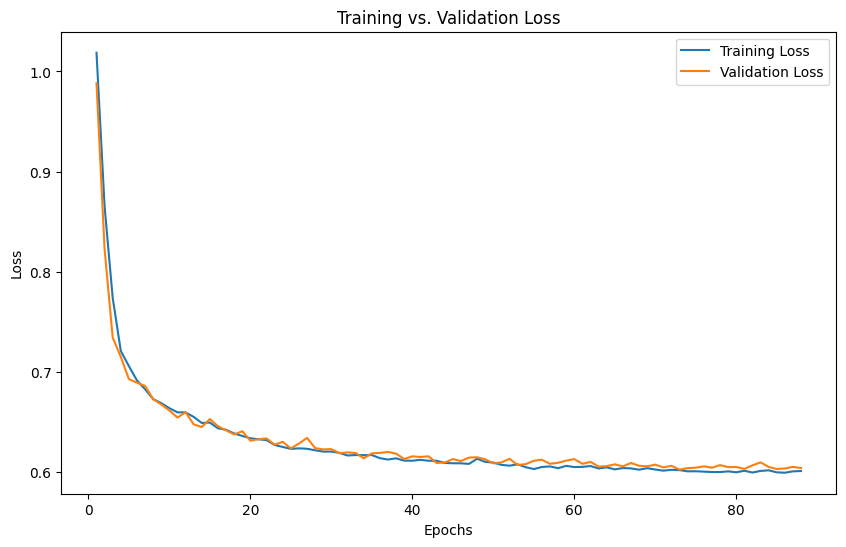

In [25]:
import matplotlib.pyplot as plt

epochs = list(range(1, epochs_run + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

### MODEL TESTING

In [26]:
def compute_iou(pred, target, num_classes=3):
    """
    Compute the Intersection over Union (IoU) for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: IoU for each class.
    """
    ious = []
    # Flatten the tensors for easier computation.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        union = pred_inds.sum().float() + target_inds.sum().float() - intersection
        if union == 0:
            ious.append(float('nan'))  # Alternatively, you might want to append 0.0
        else:
            ious.append((intersection / union).item())
    return ious

def compute_dice(pred, target, num_classes=3):
    """
    Compute the Dice coefficient for each class.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      list: Dice coefficient for each class.
    """
    dices = []
    # Flatten the tensors.
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().float()
        total = pred_inds.sum().float() + target_inds.sum().float()
        if total == 0:
            dices.append(float('nan'))
        else:
            dices.append((2 * intersection / total).item())
    return dices

def compute_confusion_matrix(pred, target, num_classes=3):
    """
    Compute a confusion matrix where the rows correspond to true classes
    and the columns correspond to predicted classes.
    Args:
      pred (torch.Tensor): Predicted tensor of shape (N, H, W)
      target (torch.Tensor): Ground truth tensor of shape (N, H, W)
      num_classes (int): Number of classes.
    Returns:
      torch.Tensor: A (num_classes, num_classes) confusion matrix.
    """
    pred = pred.view(-1)
    target = target.view(-1)
    # Use torch.bincount to count occurrences of each (true, pred) pair.
    cm = torch.bincount(num_classes * target + pred, minlength=num_classes**2)
    cm = cm.reshape(num_classes, num_classes)
    return cm

def compute_precision_recall_f1(conf_matrix):
    """
    Compute per-class precision, recall, and F1 score from a confusion matrix.
    Args:
      conf_matrix (torch.Tensor): A (num_classes, num_classes) confusion matrix.
    Returns:
      tuple: Three lists containing precision, recall, and F1 score for each class.
    """
    num_classes = conf_matrix.shape[0]
    precisions = []
    recalls = []
    f1s = []
    for i in range(num_classes):
        TP = conf_matrix[i, i].item()
        FP = conf_matrix[:, i].sum().item() - TP
        FN = conf_matrix[i, :].sum().item() - TP
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else float('nan')
        recall    = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else float('nan')
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return precisions, recalls, f1s

In [27]:
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        # Convert raw logits to predicted class labels (shape: (batch_size, H, W))
        preds = torch.argmax(outputs, dim=1)
        
        # Collect predictions and ground truth labels for metric computations
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Calculate average test loss over the dataset
test_loss = test_loss / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Concatenate all the collected predictions and labels along the batch dimension
all_preds = torch.cat(all_preds, dim=0)
print(all_preds.shape)
all_labels = torch.cat(all_labels, dim=0)
print(all_labels.shape)


# Compute metrics using the functions defined earlier
ious = compute_iou(all_preds, all_labels, num_classes=3)
dices = compute_dice(all_preds, all_labels, num_classes=3)
conf_matrix = compute_confusion_matrix(all_preds, all_labels, num_classes=3)
precisions, recalls, f1s = compute_precision_recall_f1(conf_matrix)

print("IoU per class:", ious)
print("Dice per class:", dices)
print("Confusion Matrix:\n", conf_matrix)
print("Precision per class:", precisions)
print("Recall per class:", recalls)
print("F1 per class:", f1s)


Test Loss: 0.6286
torch.Size([366, 120, 120])
torch.Size([366, 120, 120])
IoU per class: [0.5768613815307617, 0.05130608752369881, 0.09173601120710373]
Dice per class: [0.7316576838493347, 0.09760446846485138, 0.16805529594421387]
Confusion Matrix:
 tensor([[2923560, 1113103, 1028212],
        [   2649,   62125,   25119],
        [    522,    7874,  107236]])
Precision per class: [0.9989165386227843, 0.052510265387092574, 0.09239966326804054]
Recall per class: [0.5772225375749648, 0.69109941819719, 0.9273903417739034]
F1 per class: [0.731657691833156, 0.09760446820293874, 0.16805529545157144]


In [28]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score

# Example tensors (replace these with your actual data)
# predictions = torch.randint(0, 3, (366, 120, 120))
# true_labels = torch.randint(0, 3, (366, 120, 120))

# Flatten the tensors so each pixel is one element
pred_flat = all_preds.view(-1)
true_flat = all_labels.view(-1)

# 1. Pixel Accuracy
pixel_accuracy = (pred_flat == true_flat).float().mean().item()
print("Pixel Accuracy:", pixel_accuracy)

# 2. Confusion Matrix
cm = confusion_matrix(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2])
print("Confusion Matrix:\n", cm)

# 3. Precision, Recall, and F1 Score (per class)
precision = precision_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2], average=None)
recall = recall_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2], average=None)
f1 = f1_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy(), labels=[0, 1, 2], average=None)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1)

# 4. Intersection over Union (IoU) for each class
def compute_iou(pred, true, num_classes=3):
    ious = []
    for cls in range(num_classes):
        # Create masks for the current class
        pred_inds = (pred == cls)
        true_inds = (true == cls)
        # Calculate intersection and union
        intersection = (pred_inds & true_inds).sum().float()
        union = (pred_inds | true_inds).sum().float()
        if union.item() == 0:
            ious.append(float('nan'))  # Avoid division by zero if class is not present in the true labels
        else:
            ious.append((intersection / union).item())
    return ious

ious = compute_iou(pred_flat, true_flat)
print("IoU per class:", ious)

# 5. Dice Coefficient for each class
def compute_dice(pred, true, num_classes=3, eps=1e-6):
    dices = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        true_inds = (true == cls)
        intersection = (pred_inds & true_inds).sum().float()
        dice = (2 * intersection) / (pred_inds.sum() + true_inds.sum() + eps)
        dices.append(dice.item())
    return dices

dices = compute_dice(pred_flat, true_flat)
print("Dice Coefficient per class:", dices)

# 6. Cohen's Kappa
kappa = cohen_kappa_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy())
print("Cohen's Kappa:", kappa)

# 7. Balanced Accuracy
balanced_acc = balanced_accuracy_score(true_flat.cpu().numpy(), pred_flat.cpu().numpy())
print("Balanced Accuracy:", balanced_acc)


Pixel Accuracy: 0.5868474841117859
Confusion Matrix:
 [[2923560 1113103 1028212]
 [   2649   62125   25119]
 [    522    7874  107236]]
Precision per class: [0.99891654 0.05251027 0.09239966]
Recall per class: [0.57722254 0.69109942 0.92739034]
F1 Score per class: [0.73165769 0.09760447 0.1680553 ]
IoU per class: [0.5768613815307617, 0.05130608752369881, 0.09173601120710373]
Dice Coefficient per class: [0.7316576838493347, 0.09760446846485138, 0.16805529594421387]
Cohen's Kappa: 0.09729011054894798
Balanced Accuracy: 0.7319040991820195


In [29]:
print(all_preds.shape)
print(all_labels.shape)

torch.Size([366, 120, 120])
torch.Size([366, 120, 120])


In [30]:
# # Directory to save the images
# output_dir = 'PRED'
# os.makedirs(output_dir, exist_ok=True) 
# # Define a color map: 0 = red, 1 = green, 2 = blue
# color_map = {
#     0: (0, 255, 0),  # 
#     1: (0, 0, 255),  # Green
#     2: (225, 0, 0)   # Blue
# }

# # Create an RGB image for each array
# for i in range(all_preds.shape[0]):
#     # Create an empty RGB image
#     rgb_image = np.zeros((120, 120, 3), dtype=np.uint8)
    
#     # Map values to colors
#     for value, color in color_map.items():
#         rgb_image[all_preds[i] == value] = color
    
#     # Convert to PIL image and save
#     image = Image.fromarray(rgb_image)
#     image.save(os.path.join(output_dir, f'image_{i:03d}.png'))

# print(f"Saved {all_preds.shape[0]} RGB images to {output_dir}")

In [31]:
# # Directory to save the images
# output_dir = 'TRUE'
# os.makedirs(output_dir, exist_ok=True) 
# # Define a color map: 0 = red, 1 = green, 2 = blue
# color_map = {
#     0: (0, 255, 0),  # 
#     1: (0, 0, 255),  # Green
#     2: (225, 0, 0)   # Blue
# }

# # Create an RGB image for each array
# for i in range(all_labels.shape[0]):
#     # Create an empty RGB image
#     rgb_image = np.zeros((120, 120, 3), dtype=np.uint8)
    
#     # Map values to colors
#     for value, color in color_map.items():
#         rgb_image[all_labels[i] == value] = color
    
#     # Convert to PIL image and save
#     image = Image.fromarray(rgb_image)
#     image.save(os.path.join(output_dir, f'image_{i:03d}.png'))

# print(f"Saved {all_labels.shape[0]} RGB images to {output_dir}")